# Training Draft

### Preprocessing

In [1]:
import numpy as np
import tensorflow as tf

from random import randint
from time import time
from math import sqrt
import matplotlib.pyplot as plt

from process.c_parse import parse_input as c_parse
from process.py_parse import parse_input as py_parse

from db.driver import Driver

DIMENSION = 64

%matplotlib inline

In [2]:
SOURCE, ACCESS = './data/strokes.txt', 'r'

def generate_pixel_matrix(drawing):
    image = np.zeros((DIMENSION, DIMENSION))
    for stroke in drawing:
        for x, y in zip(*stroke):
            image[y][x] = 1
    return image

def display_pixel_matrix(drawing):
    plt.axis('off')
    plt.imshow(generate_pixel_matrix(drawing), cmap='Greys')
    plt.show()

def display_strokes(drawing):
    plt.axis('off')
    plt.gca().invert_yaxis()
    for stroke in drawing:
        plt.plot(*stroke, color='black')
    plt.show()

def collect_runtime_data():
    c, py = [0], [0]
    with open(SOURCE, ACCESS) as doc:
        for line in doc:
            line = line.strip()
            
            start_time = time()
            c_parse(line, normalize=True, RDP=True)
            end_time = time()
            c.append(c[-1] + 1000 * (end_time - start_time))
            
            start_time = time()
            py_parse(line, normalize=True, RDP=True)
            end_time = time()
            py.append(py[-1] + 1000 * (end_time - start_time))
    return [c, py]

def visualize_runtime_difference():
    GRAPH_TITLE = 'Comparison of Total Elapsed Runtime between C and Python Parser'
    X_LABEL = 'Input Size (records)'
    Y_LABEL = 'Time (ms)'
    c, py = collect_runtime_data()
    t = range(len(c))
    plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL)
    plt.xticks(t)
    c_trend, = plt.plot(t, c, 'r-', label='C')
    py_trend, = plt.plot(t, py, 'b-', label='Python')
    plt.legend(handles=[c_trend, py_trend])
    plt.title(GRAPH_TITLE)
    plt.show()

In [3]:
driver = Driver()
cat = c_parse(driver.find_by_catagory('cat')[9]['drawing'], normalize=True, RDP=True, epsilon=1.0)

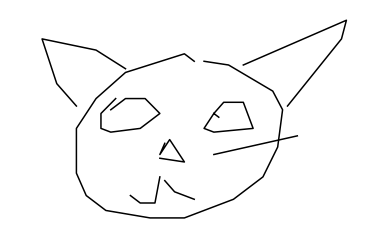

In [4]:
display_strokes(cat)

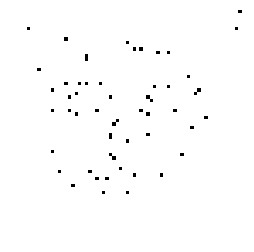

In [5]:
display_pixel_matrix(cat)

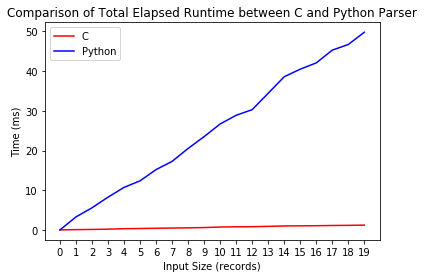

In [6]:
visualize_runtime_difference()

### Expand data

In [7]:
class Line:
    def __init__(self, start, end):
        self.__cache = {}
        self.start = start
        self.end = end
    
    def __cached(function):
        def cached_function(*argv, **kw):
            cache = argv[0].__cache
            token = tuple([function.__name__] + list(argv[1:]))
            if token not in cache:
                cache[token] = function(*argv, **kw)
            return cache[token]
        return cached_function
    
    @__cached
    def __step(self):
        vector = [e - s for s, e in zip(self.start, self.end)]
        if vector[0]:
            vector[1] /= float(abs(vector[0]))
            vector[0] /= abs(vector[0])
        elif vector[1]:
            vector[1] /= abs(vector[1])
        return vector
    
    def __check(self, x, y):
        vector = self.__step()
        if vector[0] > 0:
            return x <= self.end[0]
        elif vector[0] < 0:
            return x >= self.end[0]
        elif vector[1] > 0:
            return y <= self.end[1]
        return y >= self.end[1]
            
    def __iter__(self):
        if self.start == self.end: 
            yield self.start
        else:
            dx, dy = self.__step()
            x, y = self.start
            while self.__check(x, y):
                yield x, int(round(y))
                x, y = x + dx, y + dy

In [8]:
def expand_to_image_matrix(drawing):
    matrix = np.zeros(DIMENSION * DIMENSION)
    for stroke in drawing:
        prev = (stroke[0][0], stroke[1][0])
        for i in xrange(1, len(stroke[0])):
            current = (stroke[0][i], stroke[1][i])
            for x, y in Line(prev, current):
                matrix[y * DIMENSION + x] = 1
            prev = current
    return matrix

In [9]:
CATAGORY_MAP = {
    'airplane': 0,
    'basketball': 1, 
    'cat': 2,
    'diamond': 3,
    'envelope': 4,
    'flower': 5
}

def ImageGenerator(scope=CATAGORY_MAP.keys(), epsilon=1.0):
    cursors = [driver.find_by_catagory(c) for c in scope]
    def generator():
        while len(cursors) > 0:
            cursor_position = randint(0, len(cursors) - 1)
            cursor = cursors[cursor_position]
            try:
                obj = next(cursor)
                catagory = np.zeros(len(CATAGORY_MAP))
                catagory[CATAGORY_MAP[obj['word']]] = 1
                drawing = expand_to_image_matrix(c_parse(obj['drawing'], normalize=True, RDP=True, epsilon=epsilon))
                yield drawing, catagory
            except:
                cursors.pop(cursor_position)
    return generator

In [10]:
from tensorflow.contrib.data import Dataset

In [11]:
generator = ImageGenerator()
training = Dataset.from_generator(generator, output_types=(tf.float32, tf.float32))

def next_batch_generator(ds, batch_size, sess):
    batched_ds = ds.batch(batch_size)
    value = batched_ds.make_one_shot_iterator().get_next()
    def generator():
        return sess.run(value)
    return generator

Instructions for updating:
Use `tf.data.Dataset.from_generator()`.


### Gradient Descent

In [12]:
# Parameters
NUM_CLASSES = 6
BATCH_SIZE = 100
STEP_COUNT = 1000

sess = tf.InteractiveSession()
next_batch = next_batch_generator(training, BATCH_SIZE, sess)

# tf Graph Input
X = tf.placeholder(tf.float32, [None, DIMENSION * DIMENSION])
Y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Weights
W = tf.Variable(tf.zeros([DIMENSION * DIMENSION, NUM_CLASSES]))
b = tf.Variable(tf.zeros([NUM_CLASSES]))

sess.run(tf.global_variables_initializer())

Y = tf.matmul(X,W) + b

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

def test():
    correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    test = next_batch()
    print(accuracy.eval(feed_dict={X: test[0], Y_: test[1]}))

for index in range(STEP_COUNT):
    if not (index % 100): test()
    batch, tag = next_batch()
    train_step.run(feed_dict={X: batch, Y_: tag})

test()

0.15
0.7
0.7
0.83
0.8
0.77
0.79
0.71
0.79
0.71
0.78


### CNN

In [19]:
x = tf.placeholder(tf.float32, shape=[None, DIMENSION * DIMENSION])
y_ = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])

w = tf.Variable(tf.zeros([DIMENSION * DIMENSION, NUM_CLASSES]))
b = tf.Variable(tf.zeros([NUM_CLASSES]))

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, DIMENSION, DIMENSION, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([16 * 16 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        batch, tag = next_batch()
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch, y_: tag, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch, y_: tag, keep_prob: 0.5})
test = next_batch()
print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_: test[1], keep_prob: 1.0}))

step 0, training accuracy 0.03


InvalidArgumentError: logits and labels must be same size: logits_size=[100,10] labels_size=[100,6]
	 [[Node: SoftmaxCrossEntropyWithLogits_6 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Reshape_31, Reshape_32)]]

Caused by op u'SoftmaxCrossEntropyWithLogits_6', defined at:
  File "/home/dg/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/dg/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dg/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/dg/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/dg/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dg/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-7ae3dcf71f16>", line 47, in <module>
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1783, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 4364, in _softmax_cross_entropy_with_logits
    name=name)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/dg/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[100,10] labels_size=[100,6]
	 [[Node: SoftmaxCrossEntropyWithLogits_6 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Reshape_31, Reshape_32)]]
